# Defining Features

In [1]:
import pandas as pd
import quandl 

df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume',]]
# high - low is volatility
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
# daily movement
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

#         Price          x          x             x
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]


# Defining Labels

In [2]:
import math

forecast_col = 'Adj. Close'
#fill nan for the unavailable data
df.fillna(-99999, inplace=True)
# ceil rounds up to the nearest whole.... number of days out
# predict 1% of the future's data
# label is the 1% future's data for the same attribute adj close
# forecast out is the number of elements to be jumped.
forecast_out  =int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume  label
Date                                                            
2016-09-15      801.23  0.301412    1.420235    1543512.0    NaN
2016-09-16      797.61  0.176778   -0.176466    2092336.0    NaN
2016-09-19      795.39  1.081231   -0.714009    1121804.0    NaN
2016-09-20      799.78  0.371352   -0.027500    1048091.0    NaN
2016-09-21      805.03  0.109313    0.470509    1330556.0    NaN


# Training and Testing

Data was trained with future data (10 days later's data) and was tested, by method of cross validation

# Forecasting and prediction 

1. The predict function takes in the last 31 days as the parameter and makes prediction to the next 31 days.

2. It returns the set of data which represent the forecast set

3. In order to be able to label the x values (date values) for the forecasted set. unix date is added incrementally and is saved. so this becomes the x values for the predicted data.


# Pickling and scaling

1. Serialization of any python object - pickle
2. Pickling is used so that there would be no need to train a classifier with massive data set everytime you run the program
3. Retrain it once in a while



0.964296589406
(array([ 811.21491095,  813.36356318,  812.66188983,  812.34398885,
        810.54994081,  806.3676535 ,  810.27610196,  807.58499658,
        804.88783185,  802.33833184,  801.79055625,  798.52403466,
        796.30490357,  797.4647579 ,  800.71777825,  796.42114132,
        794.99841886,  796.74198226,  802.13244913,  811.46771586,
        812.87641499,  807.46803572,  792.2767139 ,  802.22026117,
        793.25987201,  794.54597013,  804.85690541,  802.62844977,
        799.86829175,  804.77671153,  809.82232683]), 0.96429658940609242, 31)
            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label  \
2004-08-19   50.322842  3.712563    0.324968   44659000.0  67.739104   
2004-08-20   54.322689  0.710922    7.227007   22834300.0  69.399229   
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.752232   
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  69.639972   
2004-08-25   53.164113  1.886792    1.183658    9188600.0  69.078238   
2004

/home/jayanth/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


<IPython.core.display.Javascript object>


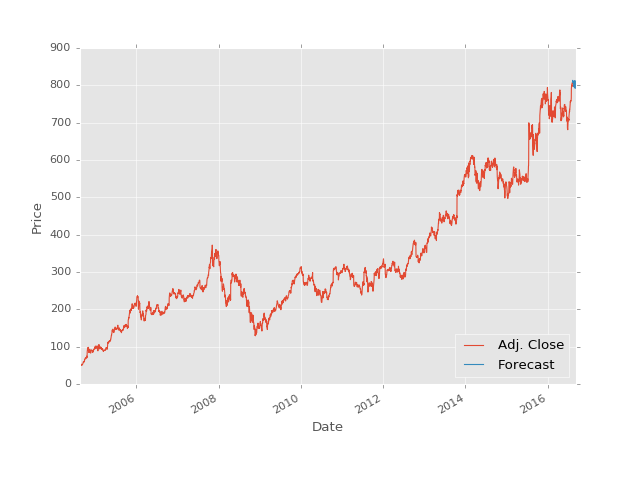

In [3]:
%matplotlib nbagg
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import time
import datetime
import pickle

style.use('ggplot')


# x is the numpy array for features and hence the label column is dropped
x = np.array(df.drop(['label'],1))
# scaling must be done not only to the old values also to the new ones..
# as there wouldn't be any feature values for the forecasted values.
x = preprocessing.scale(x)
x_lately = x[-forecast_out:]
x = x[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['label'])
# the above step was not needed as we are not considering the labels colums 


# use 20% of the data for testing..
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x,y, test_size=0.2)

#clf = LinearRegression()
#clf.fit(x_train,y_train)

# Pickling is done here
# The classifier can be commented out once the pickle file is saved
#with open('linearregression.pickle','wb') as f:
#    pickle.dump(clf, f)
    

# Uncomment the above for training it again    
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)


accuracy = clf.score(x_test,y_test)
# Squared error so accuracy is not that perfect measure.
print(accuracy)

#SVM Regressor
#clf = svm.SVR()
#clf.fit(x_train,y_train)
#accuracy = clf.score(x_test,y_test)
# Squared error so accuracy is not that perfect measure.
#print(accuracy)


#predict returns the predicted values

forecast_set  = clf.predict(x_lately)
print(forecast_set, accuracy, forecast_out)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = time.mktime(last_date.timetuple())
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()